In [3]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
from datetime import datetime
from glob import glob
from typing import List, Union, Iterator, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization, Input, Activation, Flatten,  MaxPooling2D,  Conv2D
from keras.models import Sequential, Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import EfficientNetV2B0, Xception, DenseNet201
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, History
from keras.optimizers import Adam, RMSprop, Adadelta
import keras_tuner as kt

In [4]:
def load_data(data_path: str) -> pd.DataFrame:
    """Loads data from csv file
    Params
    ------
    data_path: str
        Data path containing images and csv data
    Returns
    -------
    pd.DataFrame
        Loaded data as pandas dataframe
    """
    columns = ['image_id', 'angle', 'speed']
    data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

    return data

In [5]:
# Appends absolute path with image id column
def append_path(data: pd.DataFrame, data_path: os.PathLike) -> pd.DataFrame:
  data['image_id'] = data.image_id.apply(lambda x: os.path.join(data_path, 'training_data/', str(x)) + '.png')
  return data

## Data preprocessing

In [6]:
# train test split of dataset
def split_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Params
    ------
    data: pd.DataFrame
        Pandas dataframe containing all data.
    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of train, test and val split
    """
    rnd = np.random.RandomState(seed=None)

    train_data, val_data = train_test_split(data, test_size=0.2, random_state=rnd.seed(1234)) # split data with test size of 20%

    return train_data, val_data

In [7]:
data_path='/Users/rahuln/PycharmProjects/PiCarNet/machine-learning-in-science-ii-2023'
data = load_data(data_path)

In [8]:
data.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [9]:
data = append_path(data, data_path)

In [10]:
train_data, val_data = split_data(data)

In [11]:
# plotting distribution of output labels
def visualize(data):
    plt.hist(data.loc[:,'angle'])
    plt.hist(data.loc[:,'speed'])
    plt.legend(['Steering angle', 'Driving speed'])
    plt.title('Distribution plot for steering angle and speed')
    plt.grid(False)
    plt.show()

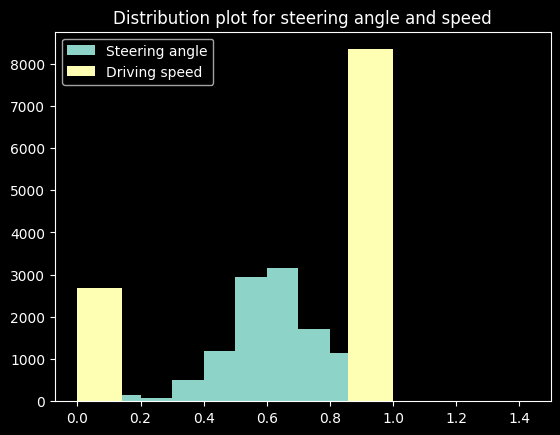

In [12]:
visualize(data=train_data)

## Data pipeline

In [13]:
# Generate images on the fly while training model
def img_generator(train_data: pd.DataFrame, val_data: pd.DataFrame, test_dir: os.PathLike, BATCH_SIZE: int, IMG_HEIGHT: int, IMG_WIDTH: int) -> Tuple[Iterator, Iterator, Iterator]:
    """
    Params
    ------
    train_data: pd.DataFrame
        Pandas dataframe containing training data
    val_data: pd.DataFrame
        Pandas dataframe containing validation data
    test_dir: os.PathLike
        path to test data directory
    BATCH_SIZE: int
        Number of images to process in each batch
    IMG_HEIGHT: int
        image height
    IMG_WIDTH: int
        image width

    Returns
    -------
    Tuple[Iterator, Iterator]
        keras ImageDataGenerators used for training and validating model.
    """

    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1]
    )

    val_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_generator.flow_from_dataframe(dataframe=train_data,
                                                          directory=None,
                                                          x_col='image_id',
                                                          y_col=['angle','speed'],
                                                          color_mode='grayscale',
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='multi_output',
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)

    val_generator = val_generator.flow_from_dataframe(dataframe=val_data,
                                                      x_col='image_id',
                                                      y_col=['angle', 'speed'],
                                                      color_mode='grayscale',
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='multi_output',
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True)
    
    test_generator = test_generator.flow_from_directory(
        directory=test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='grayscale',
        class_mode=None,
        classes=None,
        batch_size=BATCH_SIZE,
        seed=1234,
        shuffle=False)



    return train_generator, val_generator, test_generator


In [14]:
# create data generators for train test and val data
#training_ds, testing_ds, validation_ds = create_img_pipeline(train_ds, test_ds, val_ds)
BATCH_SIZE = 128
IMG_HEIGHT = 100
IMG_WIDTH = 100
test_dir = os.path.join(data_path, 'test_data')

train_generator, val_generator, test_generator = img_generator(train_data, val_data, test_dir=test_dir, BATCH_SIZE=BATCH_SIZE, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH)

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Found 1020 images belonging to 1 classes.


In [15]:
# defining callbacks
def get_callbacks(model: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple keras callbacks

    Params
    ------
    model: str
        The name of model as a string

    Returns
    -------
    A list of multiple keras callbacks
    """
    logdir = (
        'logs/scalars/' + model + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # logging for each model
    tensorboard_callback = TensorBoard(log_dir=logdir)

    early_stopping_callback = EarlyStopping(
        monitor='loss',
        min_delta=0.01,  # model should improve by at least 0.1
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=1,
        mode='min',
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        './data/models/' + model + '.h5',
        monitor='loss',
        verbose=0,
        save_best_only=True,  # save the best model
        mode='min',
        save_freq='epoch',  # save the model on disk at end of every epoch
    )
    return [model_checkpoint_callback, tensorboard_callback, early_stopping_callback]

In [16]:
# model building function
def tune_model(hp):
    """
    Build model for hyperparamter tuning

    Params
    ------
    hp: HyperParameters class instance

    Returns
    -------
    Model: Keras model object
    """
    # Define parameter tuning space
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_dropout_rate = hp.Choice(name = 'dropout_rate', values=[1e-1, 2e-1, 5e-1, 2e-2])
    hp_activation = hp.Choice(name = 'activation', values=['elu', 'relu', 'leaky_relu'], ordered=False)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-2, 1e-3, 2e-3])
    # choose optimal optimizer
    if hp.Choice('optimizer', ['Adam', 'RMSprop', 'Adadelta']) == 'Adam':
        opt = Adam(learning_rate=hp_learning_rate)
    elif hp.Choice('optimizer', ['Adam', 'RMSprop', 'Adadelta']) == 'RMSprop':
        opt = RMSprop(learning_rate=hp_learning_rate)
    else:
        opt = Adadelta(learning_rate=hp_learning_rate)

    # define input shape
    input_shape=(100, 100, 1)

    # Reference to original paper: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

    # Define model
    #mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    #mobilenet.trainable = False # Freeze the model

    # Rebuild top
    model = Sequential(name='nvidia_model')
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Flatten())
    model.add(Dropout(hp_dropout_rate))

    model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Dense(2, activation='linear'))

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics='mse')

    return model

In [17]:
tuning_dir = (
        'logs/tuned_scalars/' + 'nvidia_model' + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # dir to save tuning logs

# Define tuner
tuner = kt.BayesianOptimization(hypermodel=tune_model,
                        objective=kt.Objective('val_mse', direction='min'),
                        max_trials=3,
                        overwrite=True,
                        project_name='./data/tuned_models')

Metal device set to: Apple M1 Pro


2023-03-15 16:24:21.546386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 16:24:21.546409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


KeyboardInterrupt: 

In [ ]:
tuner.search(train_generator,
             epochs=30,
             callbacks = [EarlyStopping(monitor='val_mse', patience=5, min_delta=0.01),
                          TensorBoard(log_dir=tuning_dir)],
             batch_size=BATCH_SIZE,
             validation_data=val_generator)

In [ ]:
tuner.results_summary()

In [ ]:
best_params = tuner.get_best_hyperparameters()[0]

In [ ]:
best_model = tuner.hypermodel.build(best_params)

In [ ]:
best_model.summary()

In [ ]:
tf.keras.backend.clear_session() # clear keras session

In [ ]:
## Train model with best hyperparameters
def train(name: str, model: Model, train_generator: Iterator, val_generator: Iterator, epoch: int) -> History:
    """
    Params
    ------
    name: str
        Model name
    model: keras.models.Model
        Model we are training
    train_generator: Iterator
        Image data generator for training
    val_generator: Iterator
        Image data generator for validation
    epoch: int
        Number of epochs to train for
    Returns
    -------
    keras.callbacks.History
    """
    callbacks = get_callbacks(name)

    history = model.fit(train_generator,
              epochs=epoch,
              steps_per_epoch=300,
              validation_data=val_generator,
              validation_steps=100,
              callbacks=callbacks,
              workers=4,
              verbose=1,
              batch_size=len(train_data))

    return history

In [ ]:
nvidia_history = train(name='nvidia_model', model=best_model, train_generator=train_generator, val_generator=val_generator, epoch=50)

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'lightblue', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'coral', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Nvidia Model: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.legend()
    plt.savefig('nvidia_model_plot.pdf')
    plt.show()

In [ ]:
plot_history(nvidia_history)

In [ ]:
def get_predictions(test_path: str, test_generator: Iterator, model: Sequential) -> pd.DataFrame:
    """
    Params
    ------
    test: str
        path to test data
    test_generator: Iterator
        Data generator for testing
    model: Sequential model
        trained model to make

    Returns
    -------
    pd.DataFrame
        predictions as pandas dataframe
    """
    test_dir = os.path.join(data_path, test_path)

    # list of all png files in test data
    png_files = glob(f'{test_dir}/*png')

    # convert to pandas dataframe with image_id as column name
    png_df = pd.DataFrame(data=png_files, columns=['image_id'])
    png_df['image_id'] = png_df.image_id.apply(lambda x: os.path.split(x)[-1].split('.png')[0])

    """    
    # prepare test tensorflow dataset for making predictions
    test_ds = tf.data.Dataset.from_tensor_slices(png_files).map(
        lambda image: (tf.image.decode_png(tf.io.read_file(image), channels=1))
    ).map(
        lambda image: (tf.image.convert_image_dtype(image, dtype=tf.float32))
    ).map(
        lambda image: (tf.image.resize(image, [128, 128]))
    ).batch(32)"""

    # make predictions
    pred = model.predict(test_generator)

    # convert prediction numpy.ndarray( to pd.DataFrame
    pred_df = pd.concat([png_df, pd.DataFrame(data=pred, columns=['angle', 'speed'])], axis=1)
    # dropping index from dataframe
    pred_df.reset_index(drop=True)

    # return predictions
    return pred_df

In [ ]:
def save_csv(pred_df: pd.DataFrame) -> None:
    """
    Params
    ------
    pred_df: pd.DataFrame
        predictions in pandas dataframe

    Returns
    -------
    None
    """

    savedir='./submissions' # submissions directory
    if not os.path.exists(savedir):
        os.mkdir(savedir)

    csvfile = 'submission' + '_' + datetime.now().strftime('%d-%b_%I-%M%p') + '.csv' # csv file name
    savedir = str(os.path.join(savedir, csvfile))
    pred_df.to_csv(savedir, sep=',', index=False) # save to disk
    print('Saved CSV file on disk!')

In [ ]:
test_path = os.path.join('test_data', 'images') # path to test data
pred_df = get_predictions(test_path, test_generator, best_model)

In [ ]:
pred_df.head()

In [ ]:
save_csv(pred_df)